<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Machine Vision Learning
</font>
<hr/>
<font color="#800080" size=5>
LAB 4 : Support Vector Machines
<br>
</font>
<font size=5>
Instructor: Dr. H. Mohammad Zadeh
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
</font>

</div></font>

In [8]:
Name = "Ali Sadeghian"
SN = "400101464"

## Introduction


Support Vector Machines (SVMs) have emerged as a robust classification technique, particularly for high-dimensional data like images. Their capacity to model complex decision boundaries through the use of kernels makes them well-suited for this task. In this study, we explore the effectiveness of SVMs with both linear and Radial Basis Function (RBF) kernels for classifying emotions based on facial expressions captured in image datasets. 

To enhance the classification performance, we employ Principal Component Analysis (PCA) for dimensionality reduction, enabling the SVM models to operate more efficiently. We systematically tune the SVM parameters, including the regularization parameter $C$ and the kernel parameter $\gamma$, through cross-validation to optimize model performance. Additionally, we will compare the results of the RBF kernel SVM with a linear SVM to analyze the differences in classification accuracy and robustness. 

Through this work, we aim to contribute valuable insights into the application of machine learning techniques for emotion recognition, emphasizing the importance of hyperparameter tuning and model selection in achieving optimal results.


## Libraries

In [9]:
import zipfile
from io import BytesIO
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2
import zipfile
from PIL import Image, ImageDraw
from sklearn.linear_model import LinearRegression
import random
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import  classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Reading data

This code is designed to read, process, and visualize facial expression images from a zip file containing subfolders for different emotional categories: neutral, happy, surprise, and disgust. The key functionalities of the code are encapsulated within several defined functions that perform tasks ranging from image reading to masking and plotting.

1. **Reading Images from Zip File**: 
   - The `read_images_from_zip` function takes a path to a zip file and a specific folder within that zip file as input. It extracts all PNG images from the designated folder, converts them to grayscale, and stores them in a list. This function utilizes the `zipfile` module to handle zip file operations and the `OpenCV` library (`cv2`) for image processing.

2. **Displaying Images**: 
   - The `plot_images_random` function is responsible for randomly selecting a specified number of images from a given list and displaying them in a single figure using Matplotlib. The images are shown in grayscale, and the function allows for an optional title for the plot.

3. **Masking Images**: 
   - The `mask_face_ellipse` function creates an elliptical mask for each image to focus on the central part of the face. It calculates the center and axes of the ellipse based on the dimensions of each image and uses OpenCV's `ellipse` function to generate the mask. The mask is then applied to each image using a bitwise operation, resulting in a list of masked images.

4. **Flattening Images**: 
   - The `flatten_images` function converts each 2D image into a 1D array by flattening its pixel values. This is particularly useful for machine learning applications where images need to be represented as feature vectors.

5. **Main Execution**: 
   - The main section of the code defines paths for each emotional category within the zip file and reads the grayscale images for each emotion. It checks if images were successfully loaded and plots a random sample of five images from each category. If no images are found in a category, a message is printed to the console.

6. **Masking and Visualizing**: 
   - After reading and plotting the original grayscale images, the code applies the elliptical mask to the images of each emotion category. Finally, it plots the masked images to visualize the results of the masking process.

In [10]:
# Function to read images from a zip file and convert them to grayscale
def read_images_from_zip(zip_file_path, folder_in_zip):
    gray_images = []

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as archive:
        # Filter PNG files within the specified folder
        file_list = [f for f in archive.namelist() if f.startswith(folder_in_zip) and f.endswith(".png")]

        # Read each image and convert to grayscale
        for file in file_list:
            with archive.open(file) as img_file:
                file_bytes = np.frombuffer(img_file.read(), np.uint8)
                img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray_images.append(gray_img)

    return gray_images

In [11]:
# Function to display a set of images
def plot_images_random(images, n, title=None):

    random_indices = random.sample(range(len(images)), n)
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[random_indices[i]], cmap='gray')
        plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)  # Use suptitle for centered title
    plt.tight_layout()
    plt.show()

In [12]:
# Function to create an elliptical mask for face detection
def mask_face_ellipse(images, width_factor=0.8, height_factor=0.6):
    masked_images = []  # List to store masked images

    for image in images:
        height, width = image.shape[:2]  # Get the dimensions of the image
        center_x, center_y = width // 2, height // 2
        axis_x = int(width // 2 * width_factor)
        axis_y = int(height // 2 * height_factor)

        # Create a mask using an ellipse
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.ellipse(mask, (center_x, center_y), (axis_x, axis_y), 0, 0, 360, 255, thickness=-1)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_images.append(masked_image)  # Add the masked image to the list

    return masked_images  # Return the list of masked images

In [13]:
# Flatten the images (images is list of images)
def flatten_images(images):
    # data shape (number of images , h*w (number of pixels))
    return np.array([img.flatten() for img in images])

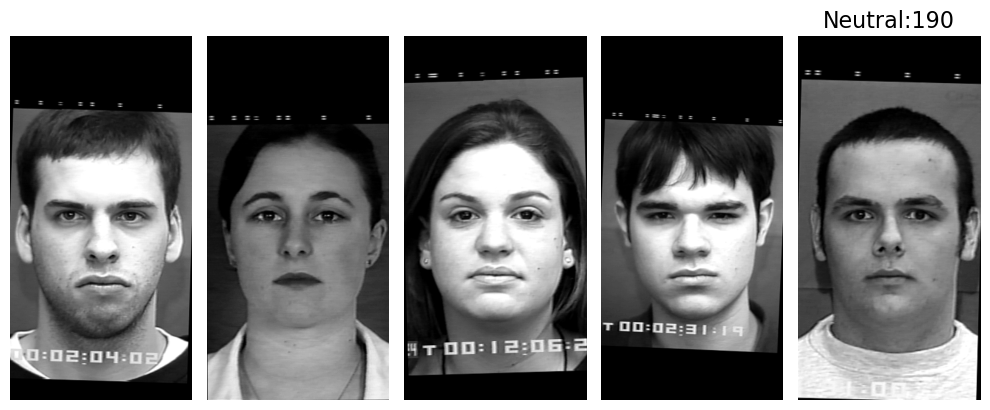

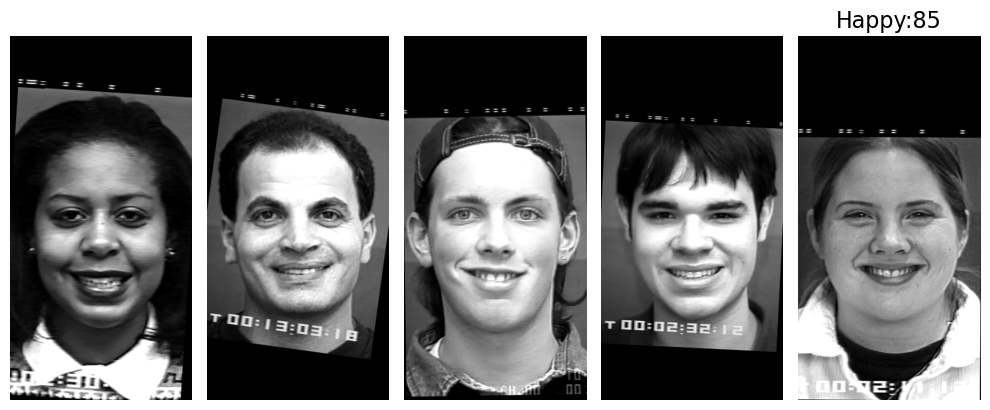

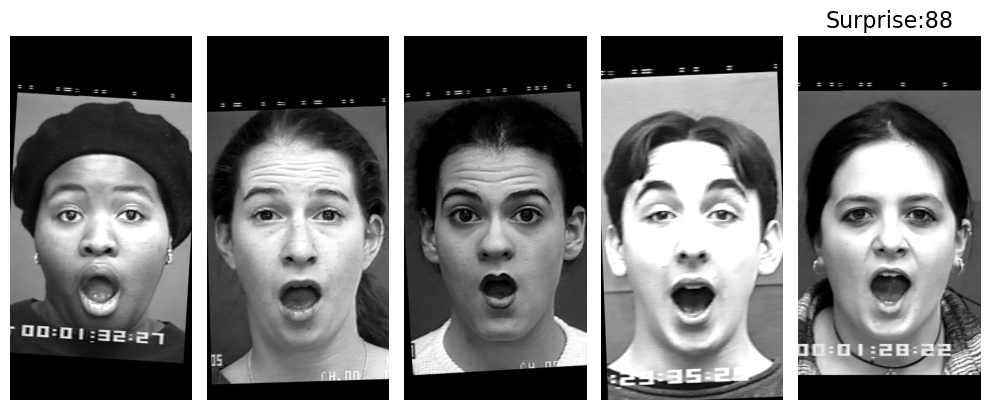

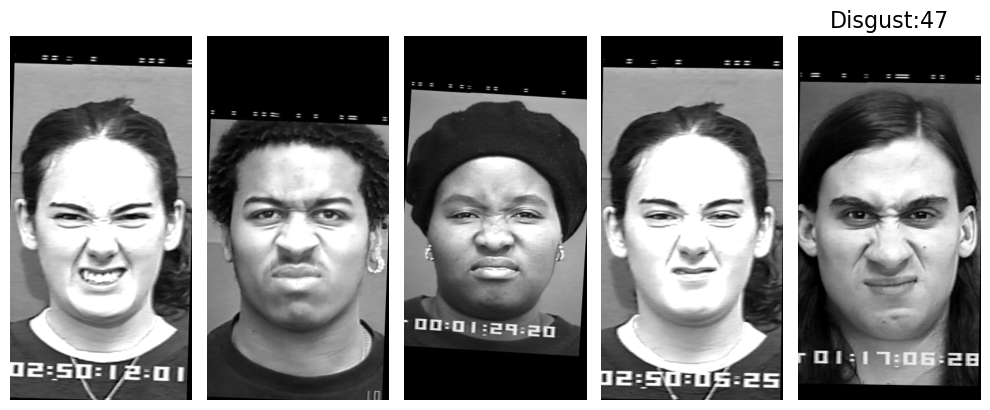

In [14]:
# Define paths for image datasets in the zip file
zip_file_path = 'data_set_image.zip'
neutral_in_zip = 'neutral/'
happy_in_zip = 'happy/'
surprise_in_zip = 'surprise/'
disgust_in_zip = 'disgust/'

# Number of images to plot
n_images_to_plot = 5

# Read images from the specified folders in the zip file
gray_images_neutral = read_images_from_zip(zip_file_path, neutral_in_zip)
gray_images_happy = read_images_from_zip(zip_file_path, happy_in_zip)
gray_images_surprise = read_images_from_zip(zip_file_path, surprise_in_zip)
gray_images_disgust = read_images_from_zip(zip_file_path, disgust_in_zip)

# Extract image dimensions for each emotion category
Height_n, Width_n = gray_images_neutral[0].shape
Height_h, Width_h = gray_images_happy[0].shape
Height_s, Width_s = gray_images_surprise[0].shape
Height_d, Width_d = gray_images_disgust[0].shape

# Check if images were found in each category and print a message if not
if len(gray_images_neutral) == 0:
    print("No images found in the specified folder Neutral.")
else:
    plot_images_random(gray_images_neutral,5,f"Neutral:{len(gray_images_neutral)}")
    
if len(gray_images_happy) == 0:
    print("No images found in the specified folder Happy.")
else:
    plot_images_random(gray_images_happy,5,f"Happy:{len(gray_images_happy)}")

if len(gray_images_surprise) == 0:
    print("No images found in the specified folder Surprise.")
else:
    plot_images_random(gray_images_surprise,5,f"Surprise:{len(gray_images_surprise)}")

if len(gray_images_disgust) == 0:
    print("No images found in the specified folder Disgust.")
else:
    plot_images_random(gray_images_disgust,5,f"Disgust:{len(gray_images_disgust)}")

In [15]:
# Apply the mask to the images
masked_images_neutral = mask_face_ellipse(gray_images_neutral)
masked_images_happy = mask_face_ellipse(gray_images_happy)
masked_images_surprise = mask_face_ellipse(gray_images_surprise)
masked_images_disgust = mask_face_ellipse(gray_images_disgust)

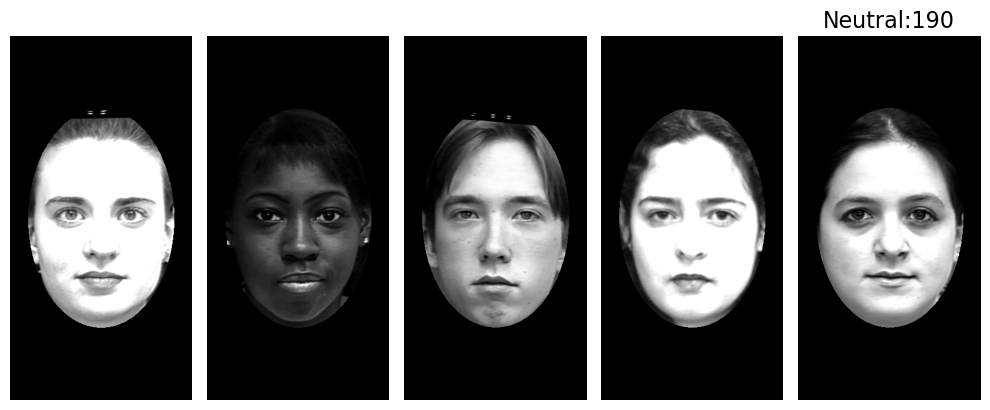

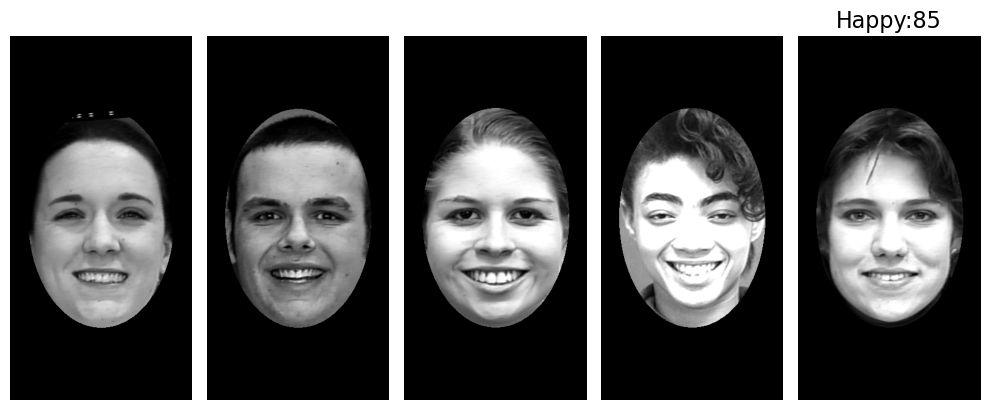

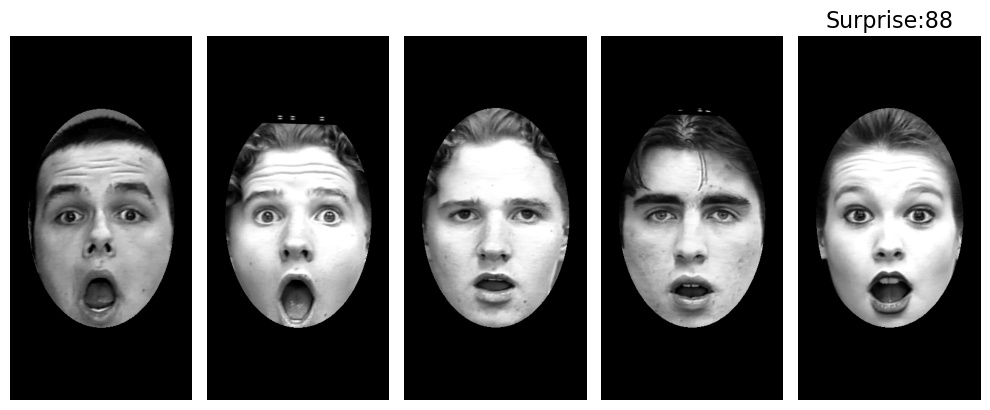

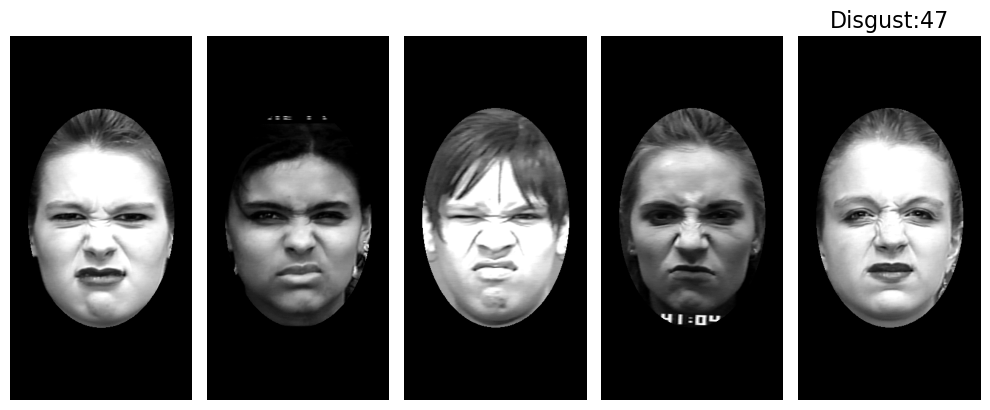

In [16]:
plot_images_random(masked_images_neutral,5,f"Neutral:{len(masked_images_neutral)}")
plot_images_random(masked_images_happy,5,f"Happy:{len(masked_images_happy)}")
plot_images_random(masked_images_surprise,5,f"Surprise:{len(masked_images_surprise)}")
plot_images_random(masked_images_disgust,5,f"Disgust:{len(masked_images_disgust)}")

##  Voting-based support vector machine (SVM) classification

This section of the code focuses on training and evaluating a voting-based support vector machine (SVM) model to classify images of facial expressions into three emotional categories: neutral, happy, and surprise. The process involves data preparation, model training, and evaluation using a voting mechanism to combine predictions from multiple SVM classifiers.

1. **Preparing Data and Labels**:
   - The code begins by flattening the masked images for each emotion category (neutral, happy, surprise) using the `flatten_images` function. This transforms each 2D image into a 1D feature vector suitable for input to the SVM classifiers.
   - Labels are assigned to each category: neutral images are labeled as `0`, happy images as `1`, and surprise images as `2`. These labels are stored in separate arrays for each category.

2. **Combining Data and Splitting**:
   - All flattened images and corresponding labels are concatenated into single arrays (`all_data` and `all_labels`). This combined dataset is then split into training and testing sets using `train_test_split`, with `20%` of the data reserved for testing.

3. **Data Standardization**:
   - To ensure that all features contribute equally to the classification, the code standardizes the data using `StandardScaler`, which scales the data to have a mean of `0` and a standard deviation of `1`.

4. **Applying PCA (Principal Component Analysis)**:
   - The code applies PCA to reduce the dimensionality of the training and testing data to `20` components. PCA helps improve the performance of SVM by reducing noise and computational load while retaining the most significant variance in the data.

5. **Training SVM Classifiers**:
   - Three binary SVM classifiers are instantiated for different emotional comparisons: 
     - `svm_neutral`: distinguishes between neutral and others.
     - `svm_happy`: distinguishes between happy and others.
     - `svm_surprise`: distinguishes between surprise and others.
   - Each SVM is trained on the PCA-transformed training data. The labels for training are adjusted to treat the specified classes as binary outputs (e.g., treating neutral as one class and the others as the second class).

6. **Voting-Based Prediction**:
   - The `vote_based_prediction` function predicts the emotion of a test sample by aggregating votes from the three trained SVM classifiers. It calculates the predicted probabilities for each class and determines which emotion has the majority vote. In the case of a tie in votes, the function resolves it by selecting the emotion with the highest confidence score.

7. **Testing and Evaluation**:
   - The code tests the model on the PCA-transformed test data using the voting-based prediction function. It calculates a confusion matrix to evaluate the performance of the classification and visualizes it using a heatmap with `seaborn`.
   - Finally, it prints a classification report that includes precision, recall, and F1-score metrics for each emotion category, providing insights into the model's performance.


In [17]:
# Prepare data and labels
neutral_data = flatten_images(masked_images_neutral)
happy_data = flatten_images(masked_images_happy)
surprise_data = flatten_images(masked_images_surprise)

neutral_labels = np.zeros(len(neutral_data))
happy_labels = np.ones(len(happy_data))
surprise_labels = np.full(len(surprise_data), 2)

# Combine all data and labels
all_data = np.concatenate([neutral_data, happy_data, surprise_data])
all_labels = np.concatenate([neutral_labels, happy_labels, surprise_labels])

# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42
)

# Standardize the data for SVM
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Apply PCA
n_components = 20  # Adjust as needed
pca = PCA(n_components=n_components)
train_data_pca = pca.fit_transform(train_data)
test_data_pca = pca.transform(test_data)

In [46]:
# Train 3 SVM classifiers with soft margin
C = 0.01  # Regularization parameter for soft-margin SVM
svm_neutral = SVC(C=C, kernel='linear', probability=True)  # Neutral vs Others
svm_happy = SVC(C=C, kernel='linear', probability=True)  # Happy vs Others
svm_surprise = SVC(C=C, kernel='linear', probability=True)  # Surprise vs Others

# Train each binary classifier
svm_neutral.fit(train_data_pca, np.where(train_labels == 0, 1, 0))   
svm_happy.fit(train_data_pca, np.where(train_labels == 1, 1, 0))  
svm_surprise.fit(train_data_pca, np.where(train_labels == 2, 1, 0)) 

SVC(C=0.01, kernel='linear', probability=True)

In [47]:
def vote_based_prediction(sample):
    votes = [0, 0, 0]  # vote counters for neutral, happy, surprise
    confidences = [0, 0, 0]  # confidence scores for each class

    # Get predictions and probabilities from each classifier
    pred_neutral = svm_neutral.predict_proba(sample.reshape(1, -1))[0]
    pred_happy = svm_happy.predict_proba(sample.reshape(1, -1))[0]
    pred_surprise = svm_surprise.predict_proba(sample.reshape(1, -1))[0]

    # Voting and confidence assignment based on each classifier's binary predictions
    if pred_neutral[1] > pred_neutral[0]:  # Neutral classifier votes for neutral
        votes[0] += 1
        confidences[0] += pred_neutral[1]
    else:  # Neutral classifier votes against neutral
        confidences[0] += pred_neutral[0]

    if pred_happy[1] > pred_happy[0]:  # Happy classifier votes for happy
        votes[1] += 1
        confidences[1] += pred_happy[1]
    else:  # Happy classifier votes against happy
        confidences[1] += pred_happy[0]

    if pred_surprise[1] > pred_surprise[0]:  # Surprise classifier votes for surprise
        votes[2] += 1
        confidences[2] += pred_surprise[1]
    else:  # Surprise classifier votes against surprise
        confidences[2] += pred_surprise[0]

    # Determine final prediction by majority vote or highest confidence in case of a tie
    max_votes = max(votes)
    if votes.count(max_votes) == 1:
        return np.argmax(votes)  # Unique max vote
    else:
        return np.argmax(confidences)  # Tie-breaking by confidence


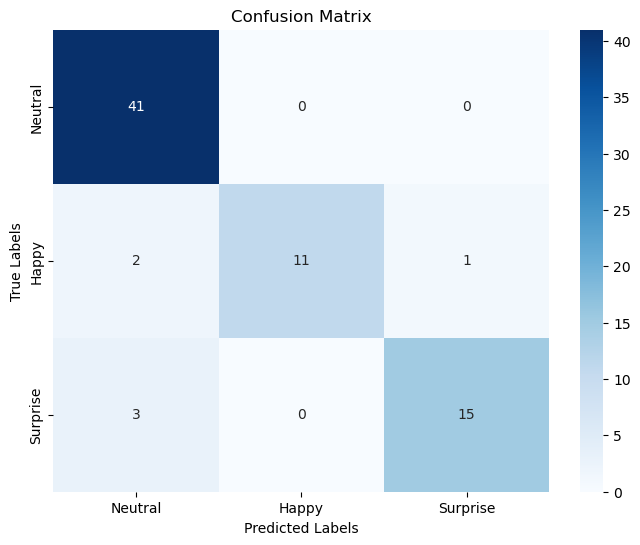


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.89      1.00      0.94        41
       Happy       1.00      0.79      0.88        14
    Surprise       0.94      0.83      0.88        18

    accuracy                           0.92        73
   macro avg       0.94      0.87      0.90        73
weighted avg       0.92      0.92      0.92        73



In [48]:
# Test the model
test_predictions = [vote_based_prediction(sample) for sample in test_data_pca]

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Happy", "Surprise"], yticklabels=["Neutral", "Happy", "Surprise"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=["Neutral", "Happy", "Surprise"]))

## Cross-Validation in Multi-Class SVM Training

Cross-validation is a robust statistical method used to estimate the skill of machine learning models. It is particularly useful in scenarios where the dataset may be limited, as it helps ensure that the model generalizes well to unseen data. In this specific implementation of a multi-class Support Vector Machine (SVM), the following steps outline how cross-validation is utilized for hyperparameter tuning, specifically for the regularization parameter $C$:

1. **Purpose of Cross-Validation**:
   - Cross-validation helps to assess how the results of a statistical analysis will generalize to an independent dataset. It is mainly used to evaluate the effectiveness of different hyperparameter settings, in this case, the regularization parameter $C$.

2. **Setup for Cross-Validation**:
   - The data is divided into $k$ subsets or "folds". The model will be trained on $k-1$ folds and tested on the remaining fold, allowing for multiple evaluations of the model performance.

3. **Iterative Training and Validation**:
   - For each value of $C$ (which varies across a predefined range):
     - The code iterates through each of the $k$ folds.
     - In each iteration, the model is trained on the data from $k-1$ folds and validated on the remaining fold. This process is repeated for all $k$ folds, ensuring that each fold serves as the validation set exactly once.
     - The training data for each fold is created by concatenating the data from the folds that are not being used for validation.

4. **Accuracy Calculation**:
   - After training the model with a specific $C$ value for each fold, the accuracy is calculated based on the predictions made on the validation fold. The accuracy for that specific $C$ is recorded.
   - Once all folds have been evaluated, the average accuracy across all folds for that $C$ value is computed. This average provides a more reliable estimate of how the model is expected to perform on unseen data.

5. **Selecting the Best Hyperparameter**:
   - After evaluating all $C$ values across all folds, the code identifies the value of $C$ that resulted in the highest average accuracy. This selected $C$ will be used to train the final SVM model.

6. **Benefits of Cross-Validation**:
   - **Reduced Overfitting**: By validating on multiple folds, the model is less likely to overfit to a specific training set. This ensures better generalization to new data.
   - **More Robust Performance Estimate**: Cross-validation provides a more stable and reliable estimate of model performance compared to using a single training-test split. It minimizes the variance associated with the random selection of training and testing data.
   - **Utilization of Data**: It maximizes the use of available data by training on nearly all of it in each iteration, which is especially important in scenarios with limited samples.

Cross-validation serves as an essential technique in model training, enabling practitioners to optimize hyperparameters effectively while ensuring that the resulting model has good generalization capabilities on unseen data. This method contributes significantly to the robustness and reliability of machine learning models, particularly in complex tasks like multi-class classification with SVM.

In [51]:
# Define the number of images to sample from each category for training
num_train_neutral = 120
num_train_happy = 60
num_train_surprise = 60
num_train_disgust = 30

# Create lists to hold training data and labels
train_images = []
train_labels = []

# Sample indices for each category for training
neutral_indices = random.sample(range(len(masked_images_neutral)), num_train_neutral)
happy_indices = random.sample(range(len(masked_images_happy)), num_train_happy)
surprise_indices = random.sample(range(len(masked_images_surprise)), num_train_surprise)
disgust_indices = random.sample(range(len(masked_images_disgust)), num_train_disgust)

# Select training images and labels using sampled indices
train_images.extend([masked_images_neutral[i] for i in neutral_indices])
train_labels.extend(["neutral"] * num_train_neutral)

train_images.extend([masked_images_happy[i] for i in happy_indices])
train_labels.extend(["happy"] * num_train_happy)

train_images.extend([masked_images_surprise[i] for i in surprise_indices])
train_labels.extend(["surprise"] * num_train_surprise)

train_images.extend([masked_images_disgust[i] for i in disgust_indices])
train_labels.extend(["disgust"] * num_train_disgust)

# 2. Remaining images for testing
test_images = []
test_labels = []

# Use all indices not in the training indices for the test set
test_neutral_images = [masked_images_neutral[i] for i in range(len(masked_images_neutral)) if i not in neutral_indices]
test_images.extend(test_neutral_images)
test_labels.extend(["neutral"] * len(test_neutral_images))

test_happy_images = [masked_images_happy[i] for i in range(len(masked_images_happy)) if i not in happy_indices]
test_images.extend(test_happy_images)
test_labels.extend(["happy"] * len(test_happy_images))

test_surprise_images = [masked_images_surprise[i] for i in range(len(masked_images_surprise)) if i not in surprise_indices]
test_images.extend(test_surprise_images)
test_labels.extend(["surprise"] * len(test_surprise_images))

test_disgust_images = [masked_images_disgust[i] for i in range(len(masked_images_disgust)) if i not in disgust_indices]
test_images.extend(test_disgust_images)
test_labels.extend(["disgust"] * len(test_disgust_images))

# Verify the results
print("Training set size:", len(train_images))
print("Training labels size:", len(train_labels))
print("Test set size:", len(test_images))
print("Test labels size:", len(test_labels))

Training set size: 270
Training labels size: 270
Test set size: 140
Test labels size: 140


In [52]:
train_flaten_iages = flatten_images(train_images)
test_flaten_images = flatten_images(test_images)

In [53]:
# Apply PCA
n_components = 20  # Adjust as needed
pca = PCA(n_components=n_components)
train_data_pca = pca.fit_transform(train_flaten_iages)
test_data_pca = pca.transform(test_flaten_images)

In [60]:
# Define cross-validation for tuning C
def cross_validate_svm_multiclass(X, y, C_values, k=5):
    n = len(X)
    fold_size = n // k
    best_C = None
    best_accuracy = 0
    avg_accuracys = []

    for C in C_values:
        accuracies = []
        
        for i in range(k):
            start, end = i * fold_size, (i + 1) * fold_size
            X_train_cv = np.concatenate((X[:start], X[end:]))
            y_train_cv = np.concatenate((y[:start], y[end:]))
            X_val_cv = X[start:end]
            y_val_cv = y[start:end]
            
            model = SVC(C=C, kernel="linear")
            model.fit(X_train_cv, y_train_cv)
            accuracies.append(model.score(X_val_cv, y_val_cv))

        

        avg_accuracy = np.mean(accuracies)
        avg_accuracys.append(avg_accuracy)
        
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_C = C

    # Plot with logarithmic scale only on the x-axis
    plt.semilogx(C_values, avg_accuracys)
    plt.title(f"Best C: {best_C}")
    plt.xlabel("C values (log scale)")
    plt.ylabel("Average Accuracy")
    plt.show()
    
    return best_C, best_accuracy

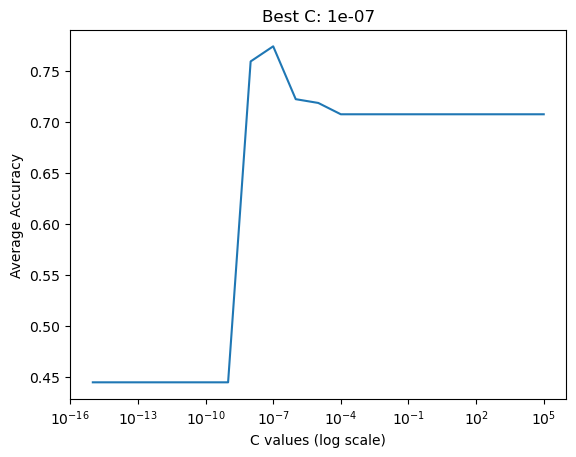

In [64]:
# Label encoding for training data
class_labels = {"neutral": 0, "happy": 1, "surprise": 2, "disgust": 3}
train_labels_encoded = np.array([class_labels[label] for label in train_labels])
test_labels_encoded = np.array([class_labels[label] for label in test_labels])

# Set C values to test
C_values = np.logspace(-15, 5, 21)  # C values from 10e-15 to 10e5

# Find best C using cross-validation
best_C, _ = cross_validate_svm_multiclass(train_data_pca, train_labels_encoded, C_values)

# Train final SVM model with the best C value
svm_model = SVC(C=best_C, kernel="linear", probability=True)
svm_model.fit(train_data_pca, train_labels_encoded)

# Test the model and make predictions
test_predictions = svm_model.predict(test_data_pca)

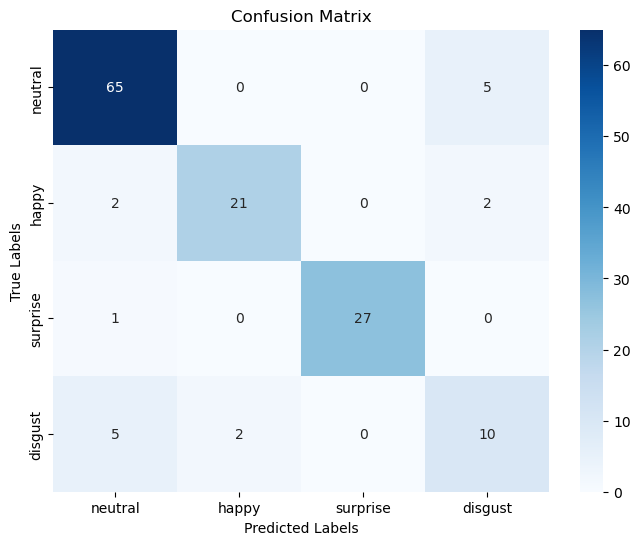


Classification Report:
              precision    recall  f1-score   support

     neutral       0.89      0.93      0.91        70
       happy       0.91      0.84      0.87        25
    surprise       1.00      0.96      0.98        28
     disgust       0.59      0.59      0.59        17

    accuracy                           0.88       140
   macro avg       0.85      0.83      0.84       140
weighted avg       0.88      0.88      0.88       140


Best C value for multi-class SVM: 1e-06


In [19]:
# Evaluate with confusion matrix, precision, and recall
conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels_encoded, test_predictions, target_names=class_labels.keys()))

# Print the best C value found
print("\nBest C value for multi-class SVM:", best_C)

## Understanding Kernels in Support Vector Machines

**What is a Kernel?**
A kernel is a function that transforms data into a higher-dimensional space to make it easier to classify. In the context of Support Vector Machines (SVM), kernels enable the model to find a hyperplane that separates different classes of data even when they are not linearly separable in the original feature space.

**Why Use Kernels?**
- **Non-linearity**: Many real-world datasets are not linearly separable. Kernels allow SVM to handle such data by projecting it into a higher-dimensional space where it can be separated by a hyperplane.
- **Efficiency**: Rather than explicitly transforming the data into a higher dimension, kernels compute the inner products between the images of the data points directly in that space. This reduces computational complexity and memory usage.

**Common Types of Kernels**:
1. **Linear Kernel**: This is the simplest kernel and is used when data can be separated linearly. It’s defined as the dot product of two vectors.
   $$
   K(x, y) = x^T y
   $$

2. **Polynomial Kernel**: This kernel can model interactions up to a specified degree. It’s useful for capturing non-linear relationships.
   $$
   K(x, y) = (x^T y + c)^d
   $$
   where $c$ is a constant and $d$ is the degree of the polynomial.

3. **Radial Basis Function (RBF) Kernel**: Also known as the Gaussian kernel, this kernel can handle non-linear relationships effectively. It measures the similarity between points and is defined as:
   $$
   K(x, y) = e^{-\gamma \|x - y\|^2}
   $$
   where $\gamma$ is a parameter that defines the width of the kernel. A small $\gamma$ means a wider kernel, and a large $\gamma$ results in a narrower kernel.


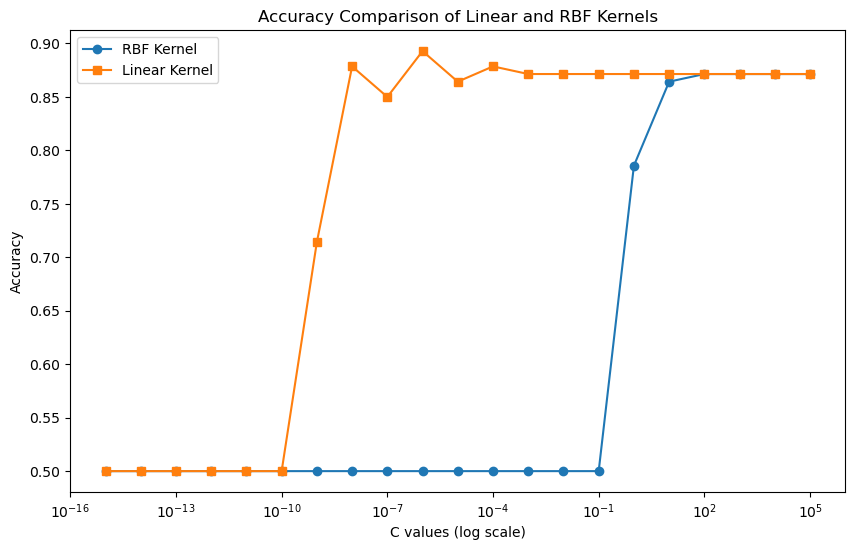

In [63]:
# Define parameter grid for GridSearchCV
C_values = np.logspace(-15, 5, 21)  # C values from 10e-15 to 10e5
accuracies_rbf = []
accuracies_linear = []

# Iterate over each C value and evaluate both linear and RBF kernels
for C in C_values:
    # RBF kernel
    rbf_svm = SVC(kernel='rbf', C=C, gamma='scale')
    rbf_svm.fit(train_data_pca, train_labels_encoded)
    rbf_predictions = rbf_svm.predict(test_data_pca)
    rbf_accuracy = accuracy_score(test_labels_encoded, rbf_predictions)
    accuracies_rbf.append(rbf_accuracy)
    
    # Linear kernel
    linear_svm = SVC(kernel='linear', C=C)
    linear_svm.fit(train_data_pca, train_labels_encoded)
    linear_predictions = linear_svm.predict(test_data_pca)
    linear_accuracy = accuracy_score(test_labels_encoded, linear_predictions)
    accuracies_linear.append(linear_accuracy)

# Plot the accuracies for both kernels
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, accuracies_rbf, label='RBF Kernel', marker='o')
plt.semilogx(C_values, accuracies_linear, label='Linear Kernel', marker='s')
plt.xlabel("C values (log scale)")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Linear and RBF Kernels")
plt.legend()
plt.show()

Best parameters for RBF SVM: {'C': 1000.0, 'gamma': 1e-10}


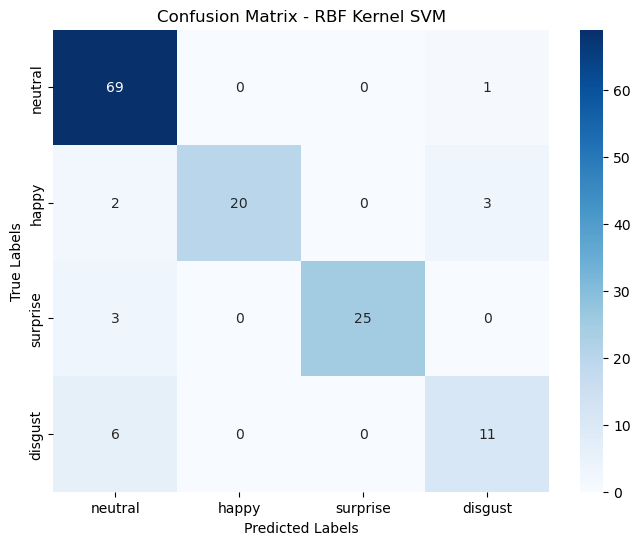


Classification Report for RBF Kernel SVM:
              precision    recall  f1-score   support

     neutral       0.86      0.99      0.92        70
       happy       1.00      0.80      0.89        25
    surprise       1.00      0.89      0.94        28
     disgust       0.73      0.65      0.69        17

    accuracy                           0.89       140
   macro avg       0.90      0.83      0.86       140
weighted avg       0.90      0.89      0.89       140

Best parameters for Linear SVM: 1e-06


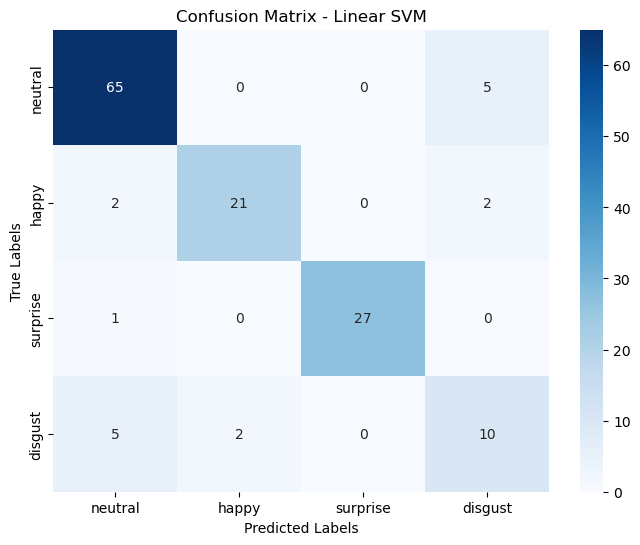


Classification Report for Linear SVM:
              precision    recall  f1-score   support

     neutral       0.89      0.93      0.91        70
       happy       0.91      0.84      0.87        25
    surprise       1.00      0.96      0.98        28
     disgust       0.59      0.59      0.59        17

    accuracy                           0.88       140
   macro avg       0.85      0.83      0.84       140
weighted avg       0.88      0.88      0.88       140



In [20]:
# Define parameter grid for GridSearchCV
param_grid = {
    'C': np.logspace(-15, 5, 21),  # C values from 10e-15 to 10e5
    'gamma': np.logspace(-15, 4, 20)  # gamma values from 10e-15 to 10e20
}
# Use GridSearchCV to find the best parameters for RBF kernel SVM
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(train_data_pca, train_labels_encoded)

# Get the best model and parameters
best_rbf_svm = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters for RBF SVM:", best_params)

# Test the RBF model on the test set
rbf_predictions = best_rbf_svm.predict(test_data_pca)

# Evaluate with confusion matrix, precision, and recall
conf_matrix = confusion_matrix(test_labels_encoded, rbf_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - RBF Kernel SVM")
plt.show()

# Print classification report
print("\nClassification Report for RBF Kernel SVM:")
print(classification_report(test_labels_encoded, rbf_predictions, target_names=class_labels.keys()))

# Compare with Linear SVM
# Train linear SVM for comparison
linear_svm = SVC(kernel='linear', C=best_C)  # Use best C from previous cross-validation
linear_svm.fit(train_data_pca, train_labels_encoded)
linear_predictions = linear_svm.predict(test_data_pca)

# Evaluate linear SVM with confusion matrix and classification report
conf_matrix_linear = confusion_matrix(test_labels_encoded, linear_predictions)
print("Best parameters for Linear SVM:", best_C)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_linear, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Linear SVM")
plt.show()

# Classification report for linear SVM
print("\nClassification Report for Linear SVM:")
print(classification_report(test_labels_encoded, linear_predictions, target_names=class_labels.keys()))

#### 1. Model Performance Overview
Both SVM models (linear and RBF) are designed to classify data into four emotional categories: neutral, happy, surprise, and disgust. The classification reports provide detailed metrics on their performance, which include precision, recall, F1-score, and overall accuracy.

#### 2. Performance Metrics Breakdown
**Linear SVM**:
- **Precision**:
  - Neutral: 0.89
  - Happy: 0.91
  - Surprise: 1.00
  - Disgust: 0.59
  - Overall average: 0.88
- **Recall**:
  - Neutral: 0.93
  - Happy: 0.84
  - Surprise: 0.96
  - Disgust: 0.59
  - Overall average: 0.88
- **F1-Score**:
  - Neutral: 0.91
  - Happy: 0.87
  - Surprise: 0.98
  - Disgust: 0.59
  - Overall average: 0.84
- **Accuracy**: 88%

**RBF Kernel SVM**:
- **Precision**:
  - Neutral: 0.86
  - Happy: 1.00
  - Surprise: 1.00
  - Disgust: 0.73
  - Overall average: 0.90
- **Recall**:
  - Neutral: 0.99
  - Happy: 0.80
  - Surprise: 0.89
  - Disgust: 0.65
  - Overall average: 0.83
- **F1-Score**:
  - Neutral: 0.92
  - Happy: 0.89
  - Surprise: 0.94
  - Disgust: 0.69
  - Overall average: 0.86
- **Accuracy**: 89%

#### 3. Key Observations

- **Precision**:
  - The RBF model shows higher precision for happy and surprise classes, indicating that when it predicts these emotions, it is correct more often than the linear model. However, the linear SVM has a higher precision for neutral, suggesting it makes fewer false positive predictions for that category.

- **Recall**:
  - The RBF model excels in recall for the neutral class, meaning it identifies nearly all neutral instances correctly. However, it struggles with the happy and disgust categories compared to the linear model, which maintains a more consistent recall across all classes.

- **F1-Score**:
  - The F1-score, which balances precision and recall, is generally better for the RBF model in the neutral and surprise categories. For the happy category, both models perform similarly, but the linear model falls behind in the disgust category.

- **Overall Accuracy**:
  - Both models have comparable accuracy, with the RBF SVM slightly ahead at 89% compared to 88% for the linear SVM.

#### 4. Confusion Matrix Insights
- The confusion matrices for both models illustrate where the models struggle:
  - The **RBF SVM** has higher false negatives in the happy and disgust classes, indicating that it misclassifies these emotions more frequently than the linear SVM.
  - The **Linear SVM** shows some misclassification of disgust as neutral, but it maintains strong performance overall, particularly in detecting surprise.

#### 5. Conclusion
Both the linear and RBF kernel SVM models demonstrate strong performance in classifying emotions from images. The choice between them can depend on the specific requirements of the application:
- **Linear SVM** may be preferred when interpretability and consistent performance across all classes, especially for disgust, is critical.
- **RBF Kernel SVM** may be more suitable for scenarios where precision in happy and surprise predictions is prioritized, as it effectively captures non-linear relationships in the data.

In practice, the final model choice can also depend on computational efficiency, as RBF SVMs can be more computationally intensive due to the kernel calculations, particularly with large datasets.